# Second home assignment Social Data Science

**Team Members:**

Xiaoqi Ma (383420) Shengjie Li (399867) Weibo Zhao (389655)

## Mahalanobis matching
Another popular alternative to propensity score matching is "Mahalanobis matching". This is a greedy matching method, where each point of one group is matched to its nearest neighbor according to the Mahalanobis distance, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.mahalanobis.html for a formal definition. 



### Data preparation:
We apply Mahalanobis matching to the quality of government (QoG) data from the last home assignment. For this task, first load the QoG data into a pandas dataframe and select the columns "cname","wdi_lifexp" (life expectancy),"wdi_popden"(population density),"gle_cgdpc" (GDP per capita), "bti_ds" (Democracy Status).

Remove all countries with missing values. Then put all remaining countries into two groups:
* Full democratic (bti_ds > 8.0)
* Not full democratic (else)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.spatial.distance import mahalanobis

%matplotlib inline

In [2]:
url = 'https://www.qogdata.pol.gu.se/data/qog_bas_cs_jan18.csv'
df = pd.read_csv(url)
df = df[["cname", "wdi_lifexp", "wdi_popden", "gle_cgdpc", "bti_ds"]]
df = df.dropna(axis=0)
df.reset_index(inplace=True) # reset index aftering removing missing values

In [3]:
df.head()

,index,cname,wdi_lifexp,wdi_popden,gle_cgdpc,bti_ds
0,0,Afghanistan,62.902683,50.176178,1282.6400,3.016667
1,1,Albania,77.998390,105.441750,8516.7002,6.950000
2,2,Algeria,75.635025,16.422152,5402.1699,4.800000
3,4,Angola,60.806732,21.593380,3771.2000,4.250000
4,6,Azerbaijan,71.724754,115.348816,9793.3096,3.483333


In [4]:
df_democratic = df[df['bti_ds'] > 8.0]
df_not_democratic = df[df['bti_ds'] <= 8.0]

### a) Compute the Mahalanobis distance matrix with respect to the attribute population density and gdp per capita.
You can use all functions from numpy/scipy/scikit-learn for this!

In [5]:
# population and gdp
pop_gdp = df[['wdi_popden', 'gle_cgdpc']].values
# calculate inversed covariance matrix
VI = np.linalg.inv(np.cov(df['wdi_popden'].values, df['gle_cgdpc'].values))
# init with zeros
md = np.zeros((df.shape[0], df.shape[0]))
for i in range(0, df.shape[0]):
    for j in range(0, df.shape[0]):
        # write distance for each element matrix
        md[i][j] = mahalanobis(pop_gdp[i], pop_gdp[j], VI)

# Mahalanobis distance matrix
md_matrix = np.asmatrix(md)

In [6]:
# show mahalonobis distances matrix
df_md_matrix = pd.DataFrame(md_matrix, index=[df['cname']], columns=[df['cname']])
df_md_matrix.head()

cname,Afghanistan,Albania,Algeria,Angola,Azerbaijan,Argentina,Bahrain,Bangladesh,Armenia,Bhutan,...,Ukraine,Macedonia,Egypt,Tanzania,Burkina Faso,Uruguay,Uzbekistan,Venezuela,Yemen,Zambia
cname,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.577240,0.361040,0.223888,0.679061,1.162822,2.543034,1.737335,0.409169,0.377909,...,0.653730,0.675497,0.341901,0.014085,0.029937,0.970537,0.494382,0.772557,0.073815,0.078496
Albania,0.577240,0.000000,0.248022,0.370988,0.101821,0.603191,2.317653,1.925810,0.169446,0.230000,...,0.089246,0.107035,0.235970,0.569015,0.597215,0.415563,0.091370,0.223550,0.504300,0.518840
Algeria,0.361040,0.248022,0.000000,0.137848,0.344323,0.803908,2.481678,1.920913,0.128535,0.018524,...,0.307174,0.329412,0.108737,0.356235,0.386237,0.611693,0.156655,0.415164,0.287925,0.291055
Angola,0.223888,0.370988,0.137848,0.000000,0.471425,0.941600,2.509833,1.854140,0.214652,0.155337,...,0.439560,0.461717,0.153128,0.219893,0.249988,0.749338,0.282317,0.552324,0.151684,0.153329
Azerbaijan,0.679061,0.101821,0.344323,0.471425,0.000000,0.508668,2.290506,1.974563,0.270886,0.325920,...,0.056133,0.046405,0.337669,0.670815,0.698966,0.325920,0.189386,0.150699,0.606106,0.620288


### b) Matching:
Investigate if there is a statistical association between "Full Democratic" and "Not Full Democratic" on one hand and life expectancy on the other hand.
For that purpose, compute a full greedy matching according to the Mahalanobis distance w.r.t population density and gdp per capita. Determine for yourself a reasonable threshold when no a match should be discarded (i.e., there is no suitable match for a country in the other group). Compare the life expectancy in the two groups.

Interpret and critically discuss the trustworthiness of the results.

In [7]:
def matching(df, distance_matrix, threshold):
    # matching_dict contains index of df_democratic as key
    # and has its nearest index of df_not_democratic as value
    matching_dict = {}
    distances = []
    df_democratic = df[df['bti_ds'] > 8.0]
    df_not_democratic = df[df['bti_ds'] <= 8.0]
    index_democ = df_democratic.index
    index_not_democ = df_not_democratic.index

    md_temp = distance_matrix.copy()
    for i in index_democ:
        match = -1
        min_d = threshold  # first set threshold to large, try to match everything
        for j in index_not_democ:
            if((md_temp[i][j] < min_d)):
                min_d = md_temp[i][j]
                match = j

        if(match != -1):
            distances.append(min_d)
            for k in index_democ:
                md_temp[k][match] = np.inf  # to avoid get matched again
            matching_dict[i] = match
    country_df = pd.DataFrame([[df['cname'][i], df['cname'][matching_dict[i]]] for i in matching_dict.keys()],
                              columns=['Full_democratic', 'Not_Full_democratic'])
    distance_df = pd.DataFrame(distances, columns=['Mahalanobis distance'])
    lifexp_df = pd.DataFrame([[df['wdi_lifexp'][i], df['wdi_lifexp'][matching_dict[i]]] for i in matching_dict.keys()],
                             columns=['democ_lifexp', 'not_democ_lifexp'])

    # combine results
    matching_df = country_df.join(distance_df, how='inner')
    matching_df = matching_df.join(lifexp_df, how='inner')
    return matching_df

In [8]:
# show relation between full democratic/not full democratic countries
# show relation between life expectancy on full democratic/not full democratic countries
first_match = matching(df, md, 10000)
first_match

,Full_democratic,Not_Full_democratic,Mahalanobis distance,democ_lifexp,not_democ_lifexp
0,Botswana,Turkmenistan,0.034920,64.694389,67.490685
1,Brazil,Peru,0.048601,74.958244,74.485367
2,Bulgaria,Mexico,0.028597,74.465851,76.699173
3,Chile,Argentina,0.032559,78.964485,76.134003
4,Costa Rica,Macedonia,0.021832,79.416855,75.358002
5,Croatia,Belarus,0.041238,77.478050,72.970734
6,Czech Republic,Saudi Arabia,0.253241,78.824387,74.397392
7,Estonia,Russia,0.056770,77.034149,70.743660
8,Jamaica,Vietnam,0.069683,75.658539,75.695290
9,"Korea, South",Oman,0.787469,82.155853,76.894562


In [9]:
# percentage for democratic has longer life expectency than not full democratic
percentage = sum(first_match['democ_lifexp'] >
                 first_match['not_democ_lifexp']) / len(first_match) * 100
print('democratic countries have {0:.2f}% cases longer life expectency'.format(
    percentage))

democratic countries have 66.67% cases longer life expectency


<font color='blue'>
First we set a high distance threshold, which means we use greedy algorithm to find a match for every full democratic country. We found out that the Mahalanobis distance between every match is small, the results seems reasonalbe. The results also show that democratic countries have 2/3 cases longer life expectency. Then we try to use lower distance threshold to further improve the match results. 

In [10]:
second_match = matching(df, md, 0.1)  # set distance threshold to 0.1
second_match

,Full_democratic,Not_Full_democratic,Mahalanobis distance,democ_lifexp,not_democ_lifexp
0,Botswana,Turkmenistan,0.034920,64.694389,67.490685
1,Brazil,Peru,0.048601,74.958244,74.485367
2,Bulgaria,Mexico,0.028597,74.465851,76.699173
3,Chile,Argentina,0.032559,78.964485,76.134003
4,Costa Rica,Macedonia,0.021832,79.416855,75.358002
5,Croatia,Belarus,0.041238,77.478050,72.970734
6,Estonia,Russia,0.056770,77.034149,70.743660
7,Jamaica,Vietnam,0.069683,75.658539,75.695290
8,Latvia,Zimbabwe,0.053508,74.124390,59.244316
9,Lithuania,Hungary,0.092993,74.517075,75.763412


In [11]:
# percentage for democratic has longer life expectency than not full democratic
percentage = sum(second_match['democ_lifexp'] >
                 second_match['not_democ_lifexp']) / len(second_match) * 100
print('democratic countries have {0:.2f}% cases longer life expectency'.format(
    percentage))

democratic countries have 61.54% cases longer life expectency


<font color='blue'>
Now we adopt distance threshold at 0.1. In comparison to previous result, we found out that some matches disappered, like 'South Korean -- Oman' by constraining on the distance threshold. And we still observe that democratic countries have longer life expectency. And the results seem trustful and reasonable. But in fact, the sample size is very small, we cannot draw further conclusions. 


# Schelling‘s Model of Segregation

### a) Create grid
Wbrite a function create_grid (shape, share_red, share_blue) that returns a numpy array of the given shape (rows, columns). Cells with a red agent should be marked with the value 1, cells with a blue agent with value 2, empty cells with a 0.

Naturally, share_red + share_blue < 1

Refrence:
[Schelling's Model of Segregation](http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/)

In [12]:
def create_grid(shape, share_red, share_blue):
    num = shape[0] * shape[1]
    red_num = int(share_red * num)
    blue_num = int(share_blue * num)
    empty_num = num - red_num - blue_num
    red = [1] * red_num
    blue = [2] * blue_num
    empty = [0] * empty_num
    
    arr = np.array(red + blue + empty)
    np.random.shuffle(arr) # shuffle the array, then reshape
    return arr.reshape(shape[0], shape[1])

In [13]:
# example
np.random.seed(2019) # make result stable
create_grid((10, 10), 0.4, 0.4)

array([[1, 2, 1, 2, 1, 0, 2, 0, 2, 2],
       [2, 1, 1, 0, 2, 2, 1, 2, 2, 2],
       [1, 1, 2, 0, 1, 1, 1, 1, 1, 2],
       [1, 2, 0, 2, 2, 1, 2, 1, 2, 0],
       [1, 1, 0, 0, 2, 2, 1, 0, 1, 0],
       [0, 2, 0, 2, 2, 2, 1, 2, 2, 1],
       [0, 1, 1, 2, 1, 1, 2, 1, 2, 2],
       [2, 1, 2, 2, 1, 1, 2, 2, 0, 0],
       [1, 1, 0, 1, 2, 0, 0, 0, 2, 2],
       [1, 1, 1, 1, 1, 2, 0, 1, 1, 2]])

### b) Visualization

Write a function visualize(grid) that take a numpy array with these properties and plots it. We recommend to use matplotlib for this

In [14]:
# Ref: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
def visualize(grid):
    # check whether there are empty agents, empty agents default with color white
    if grid.size == np.count_nonzero(grid):  
        cmap = colors.ListedColormap([ 'red', 'blue'])
    else:
        cmap = colors.ListedColormap(['white', 'red', 'blue'])
    
    fix, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap)

#     ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    return plt.show()

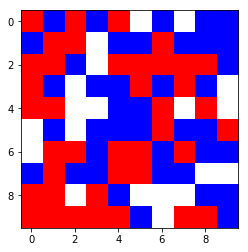

In [15]:
# example
np.random.seed(2019)
visualize(create_grid((10,10), 0.4, 0.4))

### c) Simulation Step

Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportion)

In [16]:
def simulate(grid, preferred_proportion):
    satis_score = 0
    unsatisfied = []
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            coord = (x, y)
            if grid[x][y] != 0:  # only consider those agents that are not empty
                is_unsatisfied, coord = find_unsatisfied(grid, coord, preferred_proportion)
                if is_unsatisfied == True:
                    # record the coordinates of those unsatisfied agents
                    unsatisfied.append(coord)
    
    # calculate satisfication score (only consider non-empty agents)
    satis_score = 1 - len(unsatisfied)/np.count_nonzero(grid)
    values = [grid[v[0]][v[1]] for v in unsatisfied]
    
    # shuffle the position of those unsatisfied agents
    np.random.shuffle(values)
    new_grid = grid.copy()
    for i, coord in enumerate(unsatisfied):
        new_grid[coord[0]][coord[1]] = values[i]

    return satis_score, new_grid

In [17]:
# check whether a agent is satisfied or not
def find_unsatisfied(grid, coord, proportion):
    neighborMatrix = {(-1, -1), (-1, 0), (-1, 1), (0, 1), (0, -1), (1, -1), (1, 0), (1, 1)}
    row = grid.shape[0]
    col = grid.shape[1]
    agent = grid[coord[0]][coord[1]]
    neighbors = []
    
    for n in neighborMatrix:
        new_x = coord[0] + n[0]
        new_y = coord[1] + n[1]
        # boundary check
        if (new_x >=0 and new_x < row) and (new_y >= 0 and new_y < col):
            neighbor = grid[new_x][new_y]
        else:
            neighbor = 0
        neighbors.append(neighbor)
    
    # compare the satisfication percentage with the threshold
    p = neighbors.count(agent) / np.count_nonzero(np.array(neighbors))
    # p is smaller than proportion, this agent is unsatisfied
    if p < proportion:
        return True, coord
    else:
        return False, coord

### d) Full Simulation

Write a function simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization) that performs a full simulation of Schelling's model given a specific start state by performing steps until the maximum number of steps is reached or the was no change for the given amount of steps. Every iterations_to_next_vizualization steps, a visualization of the model should be plotted.


In [18]:
def full_simulate(grid, preferred_proportion, max_steps, iterations_to_next_vizualization, no_change_steps=False):
    for m in range(max_steps):
        satis_score, new_grid = simulate(grid, preferred_proportion)
        # visualize in each designated steps
        if m in iterations_to_next_vizualization:
            print('Step:{0} Satisfication Score: {1}'.format(m, satis_score))
            visualize(grid)
        if (new_grid == grid).all():
            no_change_steps = True
            print('No changes in step: ', m)
            break
        grid = new_grid
    if no_change_steps == False:
        print('Reach the maximum steps: ', max_steps)


Step:0 Satisfication Score: 0.5347222222222222


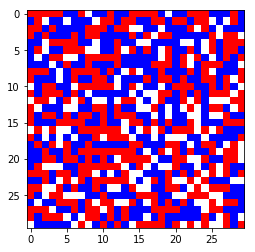

Step:5 Satisfication Score: 0.9555555555555556


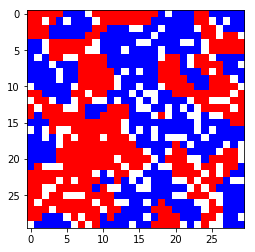

Step:10 Satisfication Score: 0.9819444444444444


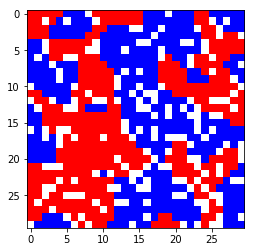

No changes in step:  11


In [19]:
np.random.seed(2019)
grid = create_grid((30,30), 0.4, 0.4)
pref_prop = 0.5
max_steps = 20
iter_to_visul = np.linspace(0, 20, 5) # [0, 5, 10, 15, 20] visualize every 5 steps
full_simulate(grid, pref_prop, max_steps, iter_to_visul)

### e) Model Extension

Edit your functions such that they support multiple groups (instead of just red and blue), and each group can have a separate preferred proportion. Use for this the following signatures

create_grid (shape, shares): percentages should be a list of shares for each color
visualize(grid) => choose appropriate colors
Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportions) => Gives a list of preferred proportions for each color.


In [20]:
def create_grid_ex(shape, shares):
    if sum(shares) <= 1:
        num = shape[0] * shape[1]
        empty_num = num  # the remaining share is empty
        share_array = []
        for i, s in enumerate(shares):
            share_num = int(s * num)
            empty_num -= share_num
            # initialize the agents with 1, 2, 3...; 0 means empty agent
            share = [i+1] * share_num
            share_array += share

        # check whethre there are empty agents
        if empty_num > 0:
            empty = [0] * empty_num
            arr = np.array(share_array + empty)
        else:
            arr = np.array(share_array)

        np.random.shuffle(arr)
        return arr.reshape(shape[0], shape[1])
    else:
        print('Make sure the sum of all shares is no larger than 1')


def visualize_ex(grid, shares):
    color_list = ['white', 'red', 'yellow',
                  'orange', 'lime', 'green', 'cyan', 'blue']
    color_num = len(shares)
    # sum(shares) = 0.99999 ?? sum([0.3, 0.3, 0.3, 0.1]) = 0.999999
    if 1 - sum(shares) < 1e-5:
        # agent1 --> red, agent2 --> yellow, etc...
        cmap = colors.ListedColormap(color_list[1:color_num+1])
    elif sum(shares) < 1:
        # white color represents empty agent
        cmap = colors.ListedColormap(color_list[0:color_num+1])
    else:
        print('Make sure the sum of all shares is no larger than 1')

    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap)

    return plt.show()


def simulate_ex(grid, preferred_proportion):
    satis_score = 0
    unsatisfied = []
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            coord = (x, y)
            if grid[x][y] != 0:  # only consider those agents that are not empty
                share_index = grid[x][y] - 1 # match the index to preferred_proportion
                is_unsatisfied, coord = find_unsatisfied_ex(grid, coord, preferred_proportion[share_index])
                if is_unsatisfied == True:
                    unsatisfied.append(coord)  # record the coordinates

    # calculate satisfication score (only consider non-empty agents)
    satis_score = 1 - len(unsatisfied)/np.count_nonzero(grid)
    values = [grid[v[0]][v[1]] for v in unsatisfied]
    np.random.shuffle(values)
    new_grid = grid.copy()
    for i, coord in enumerate(unsatisfied):
        new_grid[coord[0]][coord[1]] = values[i]

    return satis_score, new_grid


def find_unsatisfied_ex(grid, coord, proportion):
    neighborMatrix = {(-1, -1), (-1, 0), (-1, 1), (0, 1),
                      (0, -1), (1, -1), (1, 0), (1, 1)}
    row = grid.shape[0]
    col = grid.shape[1]
    neighbors = []

    agent = grid[coord[0]][coord[1]]
    for n in neighborMatrix:
        new_x = coord[0] + n[0]
        new_y = coord[1] + n[1]
        # boundary check
        if (new_x >= 0 and new_x < row) and (new_y >= 0 and new_y < col):
            neighbor = grid[new_x][new_y]
        else:
            neighbor = 0
        neighbors.append(neighbor)
    # compare the satisfication percentage with the threshold
    p = neighbors.count(agent) / np.count_nonzero(np.array(neighbors))
    if p < proportion:
        return True, coord
    else:
        return False, coord


def full_simulate_ex(grid, shares, preferred_proportion, max_steps, iterations_to_next_vizualization, no_change_steps=False):
    for m in range(max_steps):
        satis_score, new_grid = simulate_ex(grid, preferred_proportion)
        # visualize in each designated steps
        if m in iterations_to_next_vizualization:
            print('Step:{0} Satisfication Score: {1}'.format(m, satis_score))
            visualize_ex(grid, shares)
        if (new_grid == grid).all():
            no_change_steps = True
            print('No changes in step: ', m)
            break
        grid = new_grid
    if no_change_steps == False:
        print('Reach the maximum steps: ', max_steps)

Step:0 Satisfication Score: 0.24444444444444446


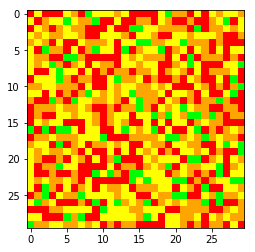

Step:10 Satisfication Score: 0.8966666666666667


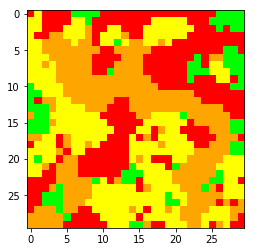

Step:20 Satisfication Score: 0.9299999999999999


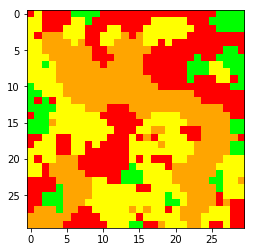

Step:30 Satisfication Score: 0.9344444444444444


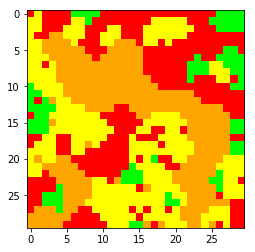

Step:40 Satisfication Score: 0.94


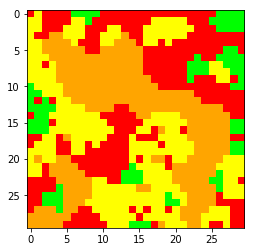

Step:50 Satisfication Score: 0.94


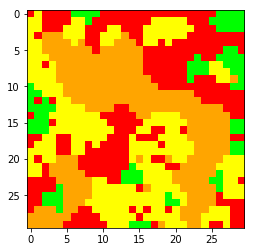

Step:60 Satisfication Score: 0.94


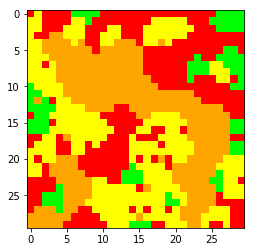

Step:70 Satisfication Score: 0.9388888888888889


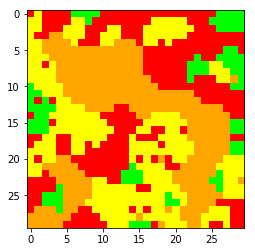

Step:80 Satisfication Score: 0.9388888888888889


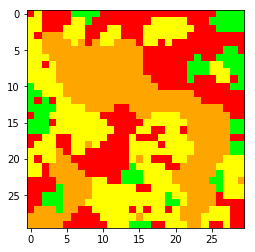

Step:90 Satisfication Score: 0.9388888888888889


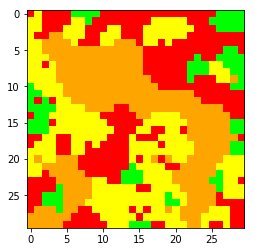

Reach the maximum steps:  100


In [22]:
np.random.seed(2019)
shares = [0.3, 0.3, 0.3, 0.1]
preferred_proportion = [0.4, 0.3, 0.5, 0.2]
iter_to_visul = np.linspace(0, 100, 11) # visualize every 10 steps
grid = create_grid_ex((30, 30), shares)
full_simulate_ex(grid, shares, preferred_proportion, 100, iter_to_visul)